In [1]:
import os
import sys
import pandas as pd
import xgboost as xgb

from xgboost import plot_importance, plot_tree

root = os.getenv("HOME")
sys.path.append(f"{root}/personal_works/walmat-recruit-forecast")
sys.path.append(f"../")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from utils.utils import date_setting
from model.naive_seasonal_year import Naive_Seasonal_Year_1lag
from model.evaluation import wmae_holiday_weight

In [3]:
train_df = pd.read_csv("../data/processed_data/train.csv")
feature_train_df = pd.read_csv("../data/processed_data/features_train_df.csv")
train_store_df = pd.read_csv("../data/processed_data/train_store.csv")

In [4]:
feature_train_df.drop(columns=["sales"], inplace=True)

In [5]:
train_df = date_setting(train_df)
feature_train_df = date_setting(feature_train_df)
train_store_df = date_setting(train_store_df)

# Seasonal Naive 1Y

In [6]:
naive_ss1y = Naive_Seasonal_Year_1lag(data=train_store_df, ts_col="sales")
pred_naive_ss17 = naive_ss1y.pred()

train_store_df = pd.merge(
    left=train_store_df,
    right=pred_naive_ss17,
    left_on=["Store", "Date"],
    right_on=["Store", "Date"],
    how="left",
)

eval_naive_ss1y = wmae_holiday_weight(
    data=train_store_df, prediction_cols=["pred_naive_lag1y"]
)

In [7]:
eval_naive_ss1y

,prediction,wmae_holiday_train
0,pred_naive_lag1y,39912.108215


# XGBoost NAIVE

In [8]:
#Test with store 20
train_store_20_df = train_store_df[train_store_df.Store == 20].copy()
train_store_20_df = pd.merge(
    left=train_store_20_df[["sales"]],
    right=feature_train_df[feature_train_df.Store == 20],
    left_index=True,
    right_index=True,
    how="left",
)

train_store_20_df = train_store_20_df.astype({"week": "int32"})

In [9]:
y_train = train_store_20_df[["sales"]]
x_train = train_store_20_df.drop(columns=["sales", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"])

In [13]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

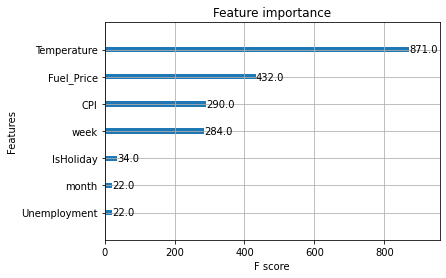

In [14]:
plot_importance(xgb_model)